---

## Data Analysis

- This file analyzes the base cleaned data created in [1_data_cleaning.ipynb](1_data_cleaning.ipynb).
    - No further manipulation of the dataset is performed in this file.
- Source dataset: 247076 rows × 37 columns
- Processed and analyzed dataset: 247076 rows × 37 columns

---

In [1]:
# package imports go here
import pandas as pd
import numpy as np
import fastparquet as fp
import os
import sys
import pickle
import matplotlib.pyplot as plt
import importlib
import config
import time

sys.path.insert(1, config.package_path)
import ml_analysis as mlanlys

---

## 1. Read the cleaned dataset from file

---

In [2]:
# reload any changes to Config Settings
importlib.reload(config)

# BE SURE TO UPDATE THE LABEL FOR THIS ANALYSIS
# #############################
dataset_label = '1 Base Dataset'
# #############################

year                        = config.year

clean_file                  = config.clean_file
performance_report          = config.performance_report

report_path                 = config.report_path
file_label                  = dataset_label.lower().replace(' ','_')
detailed_performance_report = report_path + file_label + '_detailed_performance_report.txt'

print(f"Year:                        {year}")
print(f"Clean File:                  {clean_file}")
print(f"Performance Report:          {performance_report}")
print(f"Detailed Performance Report: {detailed_performance_report}")

Year:                        2015
Clean File:                  data/brfss_2015_clean.parquet.gzip
Performance Report:          reports/performance_report.pkl
Detailed Performance Report: reports/1_base_dataset_detailed_performance_report.txt


In [3]:
start_time = time.time()

In [4]:
# Read final cleaned dataset from parquet file
df = pd.read_parquet(clean_file, engine="fastparquet")

In [5]:
diabetes_labels = df.columns

---

## 2. Prepare the dataset for analysis

---

#### 2.1 Check for feature correlation.  
- This should have been address already in [1_data_cleaning.ipynb](1_data_cleaning.ipynb) which created the base dataset used here.

---

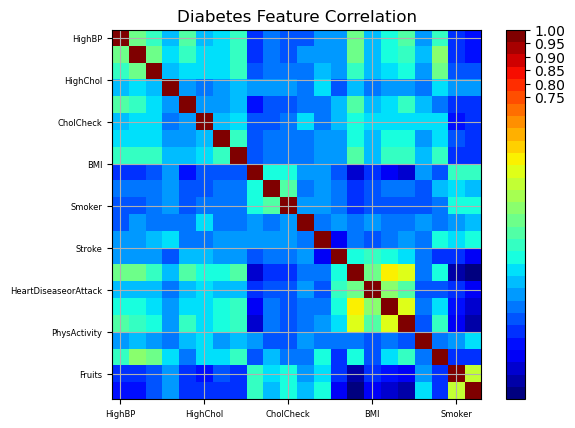

In [6]:
def correlation_matrix(df, labels):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Diabetes Feature Correlation')
#    labels=['Sex','Length','Diam','Height','Whole','Shucked','Viscera','Shell','Rings',]
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()

correlation_matrix(df, diabetes_labels)

**Note:** There is little to no cross correlation

---

### 2.2 Prepare the dataset (train/test data)

- Split the dataset into features and labels.
- Split the dataset into training and testing sets.

---

In [7]:
from sklearn.datasets import make_regression, make_swiss_roll
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
df.columns

Index(['diabetes', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [9]:
X = df.copy().drop(columns=["diabetes"])
y = df['diabetes']

In [10]:
# Create Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
data    = [X_train, X_test, y_train, y_test]

In [12]:
X_train, X_test, y_train, y_test = data
print(f"Dataframe: {df.shape}  Data:{len(data)}, X_train:{len(X_train)}, y_train:{len(y_train)}, X_test:{len(X_test)}, y_test:{len(y_test)}")
y_train.value_counts()

Dataframe: (253680, 22)  Data:4, X_train:190260, y_train:190260, X_test:63420, y_test:63420


diabetes
0.0    160219
2.0     26595
1.0      3446
Name: count, dtype: int64

In [13]:
y_test.value_counts()

diabetes
0.0    53484
2.0     8751
1.0     1185
Name: count, dtype: int64

---

## 3. Run initial Tests and get k_value

---

k: 1, Train/Test Score: 0.992/0.777
k: 3, Train/Test Score: 0.886/0.821
k: 5, Train/Test Score: 0.869/0.830
k: 7, Train/Test Score: 0.862/0.836
k: 9, Train/Test Score: 0.859/0.839


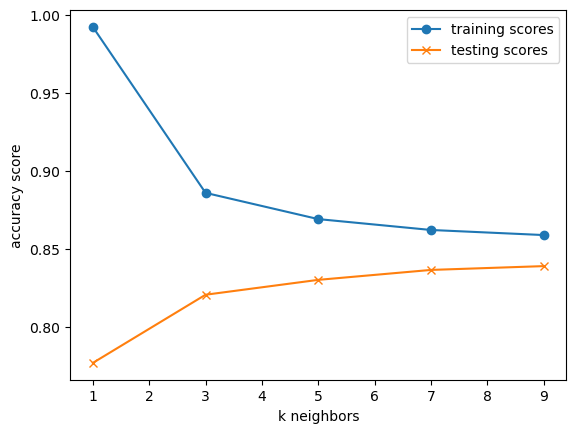

In [14]:
# reload any changes to mlanlys
importlib.reload(mlanlys)

# Determine the k_value
mlanlys.knn_plot(data)

**Note:** From the knn plot above, pick a k-value of 3.

---

## 4. Run the Analysis

---

#### Model Run Times

-  Base dataset (247076 rows × 37 columns):

| Model | Run Time |
| ----- | -------- |
| test_model(SVC(kernel='linear'), data)                          | Aborted >35min (Data too large, consider for RandomUndersampling dataset) |
| test_model(KNeighborsClassifier(n_neighbors=k_value), data)     | 247.13 seconds |
| test_model(tree.DecisionTreeClassifier(), data)                 |   3.89 seconds |
| test_model(RandomForestClassifier(), data)                      |  60.94 seconds |
| test_model(ExtraTreesClassifier(random_state=1), data)          |  58.54 seconds |
| test_model(GradientBoostingClassifier(random_state=1), data)    | 115.21 seconds |
| test_model(AdaBoostClassifier(random_state=1), data)            |  11.91 seconds |
| test_model(LogisticRegression(), data)                          |   4.90 seconds |
| **Total** w/o SVC| 502.52 seconds / **8:23 minutes** |

In [15]:
# reload any changes to nlanlys
importlib.reload(mlanlys)

k_value = 3

#### COMMENT OUT ONE OF THE FOLLOWING SECTIONS

## SECTION 1
# Capture stdout & stderr into two strings: osc.stdout and osc.stderr that contain the output from the function
# -- This allows the output to be printed here or to a file or both.

with mlanlys.OutStreamCapture() as osc:
    performance_summary = mlanlys.run_classification_models(data, k_value)
#    performance_summary = mlanlys.run_classification_models_test(data, k_value)

## <OR>
## SECTION 2

#performance_summary = mlanlys.run_classification_models(data, k_value)


In [16]:
# UNCOMMENT if using SECTION 1 in the previous step
# print(osc.stdout)

# Add code to print osc.stdout to a file if desired.

---

### 4.1 Archive Performance Summary

- For use in Project-2 Performance Summary Report
---

In [17]:
# performance_summary is a dataframe of performance statistics

# Add the dataset label as the first column in performance_summary
dataset_column = pd.Series([dataset_label] * len(performance_summary), name=dataset_label)
performance_summary.insert(0, 'new_column', dataset_column)

analysis_perf_summary = { 'dataset_size': list(df.shape), 'report': performance_summary}

# Performance_report is a file containing all the performance summary statistics
if os.path.exists(performance_report):
    print(f"The file {performance_report} exists.")
    # Load Performance Report
    with open(performance_report, 'rb') as file: perf_report = pickle.load(file)
else:
    print(f"The file {performance_report} does not exist.")
    perf_report = {}
    
perf_report[dataset_label] = analysis_perf_summary

# Save Performance Report
with open(performance_report, 'wb') as file: pickle.dump(perf_report, file)

The file reports/performance_report.pkl exists.


### 4.2 Archive the Performance Detailed Statistics Report
---

In [18]:
# osc.stdout contains the details of the performance statistics

with open(detailed_performance_report, "w") as file:
    file.write(osc.stdout)

---

## 5. Performance Summary

---

In [19]:
# print the performance summary
print(f"******************************************")
print(f"Performance Summary for: {dataset_label}")
print(f"******************************************")

performance_summary

******************************************
Performance Summary for: 1 Base Dataset
******************************************


,new_column,model,slice,score,balanced_accuracy,roc_auc_score,Mean Squared Error,Accuracy,Precision,Recall,F1-score,Specificity,False Positive Rate,Matthews Correlation Coefficient
0,1 Base Dataset,KNeighborsClassifier,Train,0.8859,0.4969,0.9473,0.4034,0.9021,0.7339,0.4703,0.5732,0.9723,0.0277,NaN
1,1 Base Dataset,KNeighborsClassifier,Test,0.8205,0.3899,0.6198,0.6582,0.8370,0.3587,0.2303,0.2805,0.9341,0.0659,0.1995
2,1 Base Dataset,DecisionTreeClassifier,Train,0.9935,0.9687,0.9999,0.0227,0.9945,0.9988,0.9616,0.9798,0.9998,0.0002,NaN
3,1 Base Dataset,DecisionTreeClassifier,Test,0.7671,0.4068,0.5691,0.8074,0.7980,0.2897,0.3194,0.3038,0.8747,0.1253,0.1864
4,1 Base Dataset,RandomForestClassifier,Train,0.9935,0.9695,0.9995,0.0228,0.9944,0.9942,0.9659,0.9798,0.9991,0.0009,19.5698
5,1 Base Dataset,RandomForestClassifier,Test,0.8422,0.3868,0.7381,0.5726,0.8597,0.4795,0.1924,0.2746,0.9666,0.0334,0.2398
6,1 Base Dataset,ExtraTreesClassifier,Train,0.9935,0.9687,0.9999,0.0227,0.9945,0.9988,0.9616,0.9798,0.9998,0.0002,NaN
7,1 Base Dataset,ExtraTreesClassifier,Test,0.8340,0.3855,0.7191,0.6017,0.8521,0.4228,0.1964,0.2682,0.9571,0.0429,0.2161
8,1 Base Dataset,GradientBoostingClassifier,Train,0.8503,0.3926,0.7952,0.5447,0.8666,0.5638,0.2006,0.2959,0.9748,0.0252,0.2797
9,1 Base Dataset,GradientBoostingClassifier,Test,0.8502,0.3895,0.7893,0.5431,0.8671,0.5533,0.1916,0.2846,0.9752,0.0248,0.2698


In [20]:
print(f"Completed: Execution Time %s seconds:" % round((time.time() - start_time),2) )

Completed: Execution Time 784.51 seconds:


---

## 6. Conclusions

- A first glance at the summary, it appears that the Boosting models may have performed well with test/train scores were >.8 and similar in scale (<.02 delta).  However, the poor test confusion matrix and balanced accuracy highlight the overfitting.

- The Base Cleaned data is overfit as indicated by:
    - Poor confusion matrix on the detailed report for test sets on all models
    - Low balanced accuracy as compared to the model score (less than 50%)


---

---